In [134]:
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from PIL import Image
import os
import shutil
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras import regularizers
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from keras.callbacks import Callback
from scipy.stats import sem, t
from scipy import mean
import seaborn as sns

### Подготовка данных 

In [135]:
original_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\INRIAPerson'
pos_train_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\INRIAPerson\\Train\\pos'
neg_train_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\INRIAPerson\\Train\\neg'
pos_test_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\INRIAPerson\\Test\\pos'
neg_test_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\INRIAPerson\\Test\\neg'

In [136]:
print('Total train pos images:', len(os.listdir(pos_train_dir)))
print('Total train neg images:', len(os.listdir(neg_train_dir)))
print('Total test pos images:', len(os.listdir(pos_test_dir)))
print('Total test neg images:', len(os.listdir(neg_test_dir)))

Total train pos images: 614
Total train neg images: 1218
Total test pos images: 288
Total test neg images: 453


In [137]:
work_dir = 'C:\\Users\\Anton.Lahunou\\detect_people_task\\real_data'

In [138]:
work_pos_dir = os.path.join(work_dir, 'pos')
os.mkdir(work_pos_dir)

In [139]:
work_neg_dir = os.path.join(work_dir, 'neg')
os.mkdir(work_neg_dir)

In [140]:
pos_train_files = os.listdir(pos_train_dir)
i = 0
for file_name in pos_train_files:
    full_file_name = os.path.join(pos_train_dir, file_name)
    if i<600:
        shutil.copy(full_file_name, work_pos_dir)
    if i>=600:
        break
    i += 1

In [141]:
pos_train_files = os.listdir(pos_test_dir)
i = 0
for file_name in pos_train_files:
    full_file_name = os.path.join(pos_test_dir, file_name)
    if i<240:
        shutil.copy(full_file_name, work_pos_dir)
    if i>=240:
        break
    i += 1

In [142]:
neg_train_files = os.listdir(neg_train_dir)
i = 0
for file_name in neg_train_files:
    full_file_name = os.path.join(neg_train_dir, file_name)
    if i<600:
        shutil.copy(full_file_name, work_neg_dir)
    if i>=600:
        break
    i += 1

In [143]:
neg_train_files = os.listdir(neg_test_dir)
i = 0
for file_name in neg_train_files:
    full_file_name = os.path.join(neg_test_dir, file_name)
    if i<240:
        shutil.copy(full_file_name, work_neg_dir)
    if i>=240:
        break
    i += 1

In [144]:
print('Total pos images:', len(os.listdir(work_pos_dir)))
print('Total neg images:', len(os.listdir(work_neg_dir)))

Total pos images: 840
Total neg images: 840


### Преобразование данных

In [145]:
datagen = ImageDataGenerator(rescale=1./255)

In [146]:
generator = datagen.flow_from_directory(work_dir, target_size=(150, 150), batch_size=1680, shuffle=True, class_mode='binary')

Found 1680 images belonging to 2 classes.


In [147]:
for data_batch, labels_batch in generator:
    images = data_batch
    labels = labels_batch
    break

In [148]:
print(images.shape)
print(labels.shape)

(1680, 150, 150, 3)
(1680,)


In [149]:
def confidence_interval(data):
    confidence = 0.95
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)
    start = m - h
    end = m + h
    return start, end

In [151]:
k = 6
samples = len(images) // k

### Конструирование базовой модели с полносвязными слоями

In [150]:
def build_dense_model():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(150, 150, 3)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model

In [153]:
train_data = images[samples:]
train_targets = labels[samples:]
test_data = images[:samples]
test_targets = labels[:samples]
model = build_dense_model()
history = model.fit(train_data, train_targets, epochs=50, batch_size=64, validation_split=0.2)
results = model.evaluate(test_data, test_targets)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 5s 5ms/step - loss: 0.6609 - acc: 0.6741 - val_loss: 0.4107 - val_acc: 0.8571
Epoch 2/50
1120/1120 [==============================] - 2s 1ms/step - loss: 0.4701 - acc: 0.7866 - val_loss: 0.3733 - val_acc: 0.8821
Epoch 3/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4374 - acc: 0.8036 - val_loss: 0.5463 - val_acc: 0.7286
Epoch 4/50
1120/1120 [==============================] - 1s 1ms/step - loss: 0.4389 - acc: 0.8107 - val_loss: 0.7751 - val_acc: 0.6000
Epoch 5/50
1120/1120 [==============================] - 2s 1ms/step - loss: 0.4550 - acc: 0.7964 - val_loss: 0.3149 - val_acc: 0.8857
Epoch 6/50
1120/1120 [==============================] - 2s 1ms/step - loss: 0.4220 - acc: 0.8089 - val_loss: 0.3134 - val_acc: 0.8857
Epoch 7/50
1120/1120 [==============================] - 2s 1ms/step - loss: 0.3949 - acc: 0.8241 - val_loss: 0.3342 - val_acc: 0.8571
Epoch 8/50
1120

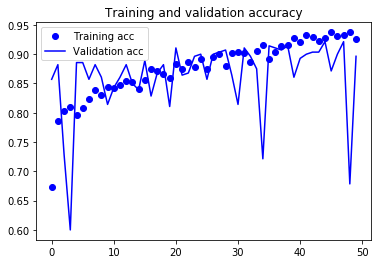

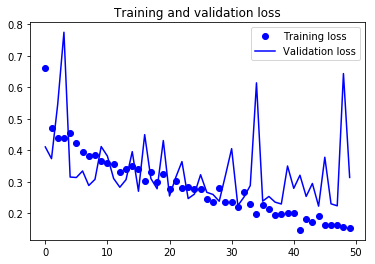

In [154]:
plt.plot(history.history['acc'], 'bo', label='Training acc')
plt.plot(history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [155]:
results

[0.4149855903216771, 0.8678571445601327]

### Конструирование простой сверточной нейронной сети 

In [159]:
def build_simple_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model

In [160]:
train_data = images[samples:]
train_targets = labels[samples:]
test_data = images[:samples]
test_targets = labels[:samples]
model = build_simple_cnn()
history = model.fit(train_data, train_targets, epochs=50, batch_size=64, validation_split=0.2)
results = model.evaluate(test_data, test_targets)

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 71s 63ms/step - loss: 0.5675 - acc: 0.7188 - val_loss: 0.4089 - val_acc: 0.8286
Epoch 2/50
1120/1120 [==============================] - 61s 55ms/step - loss: 0.3551 - acc: 0.8661 - val_loss: 0.3039 - val_acc: 0.8857
Epoch 3/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.3254 - acc: 0.8741 - val_loss: 0.2928 - val_acc: 0.8750
Epoch 4/50
1120/1120 [==============================] - 62s 55ms/step - loss: 0.2778 - acc: 0.9018 - val_loss: 0.4136 - val_acc: 0.8143
Epoch 5/50
1120/1120 [==============================] - 61s 55ms/step - loss: 0.2916 - acc: 0.8848 - val_loss: 0.2662 - val_acc: 0.9036
Epoch 6/50
1120/1120 [==============================] - 61s 55ms/step - loss: 0.2698 - acc: 0.8955 - val_loss: 0.2675 - val_acc: 0.8964
Epoch 7/50
1120/1120 [==============================] - 62s 55ms/step - loss: 0.2618 - acc: 0.8973 - val_loss: 0.2476 - val_acc: 0.8929
E

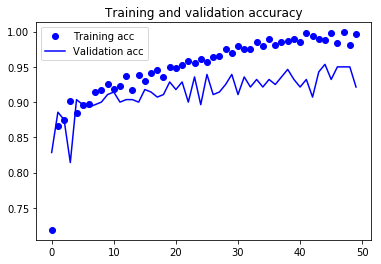

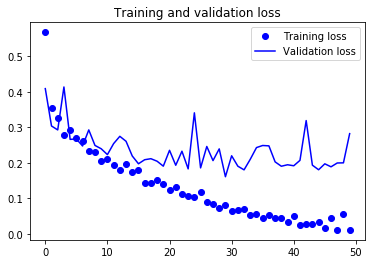

In [161]:
plt.plot(history.history['acc'], 'bo', label='Training acc')
plt.plot(history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(history.history['loss'], 'bo', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [162]:
results

[0.2954931774309703, 0.9071428554398673]

### Сверточная нейронная сеть с использованием регуляризации и  добавлением dropout слоя

In [163]:
def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
    return model

In [164]:
cnn_score = []
cnn_loss = []
cnn_validation_score = []
cnn_validation_loss = []
test_acc = []
test_loss = []

In [165]:
for fold in range(k):
    test_data = images[samples * fold:samples * (fold+1)]
    test_targets = labels[samples * fold:samples * (fold+1)]
    validation_data = images[samples * (fold+1):samples * (fold+2)]
    validation_targets = labels[samples * (fold+1):samples * (fold+2)]
    train_data = np.concatenate([images[:samples * fold], images[samples * (fold+2):]], axis=0)
    train_targets = np.concatenate([labels[:samples * fold], labels[samples * (fold+2):]], axis=0)
    model1 = build_cnn()
    history = model1.fit(train_data, train_targets, epochs=50, batch_size=64, validation_data=(validation_data, validation_targets))
    cnn_score.append(history.history['acc'])
    cnn_loss.append(history.history['loss'])
    cnn_validation_score.append(history.history['val_acc'])
    cnn_validation_loss.append(history.history['val_loss'])
    results = model1.evaluate(test_data, test_targets)
    test_acc.append(results[0])
    test_loss.append(results[1])

Train on 1120 samples, validate on 280 samples
Epoch 1/50
1120/1120 [==============================] - 65s 58ms/step - loss: 11.4467 - acc: 0.6670 - val_loss: 10.5281 - val_acc: 0.4821
Epoch 2/50
1120/1120 [==============================] - 61s 54ms/step - loss: 9.7007 - acc: 0.7955 - val_loss: 8.9592 - val_acc: 0.8429
Epoch 3/50
1120/1120 [==============================] - 61s 55ms/step - loss: 8.4303 - acc: 0.8616 - val_loss: 7.8614 - val_acc: 0.8429
Epoch 4/50
1120/1120 [==============================] - 61s 55ms/step - loss: 7.4078 - acc: 0.8652 - val_loss: 7.0071 - val_acc: 0.8071
Epoch 5/50
1120/1120 [==============================] - 61s 55ms/step - loss: 6.5197 - acc: 0.8732 - val_loss: 6.0884 - val_acc: 0.8464
Epoch 6/50
1120/1120 [==============================] - 61s 55ms/step - loss: 5.7012 - acc: 0.8884 - val_loss: 5.3276 - val_acc: 0.8643
Epoch 7/50
1120/1120 [==============================] - 61s 55ms/step - loss: 4.9891 - acc: 0.8866 - val_loss: 4.6728 - val_acc: 0.8643

Epoch 10/50
1120/1120 [==============================] - 61s 54ms/step - loss: 3.3123 - acc: 0.8893 - val_loss: 3.1747 - val_acc: 0.8714
Epoch 11/50
1120/1120 [==============================] - 61s 54ms/step - loss: 2.9145 - acc: 0.9098 - val_loss: 2.8087 - val_acc: 0.8786
Epoch 12/50
1120/1120 [==============================] - 61s 54ms/step - loss: 2.6027 - acc: 0.8902 - val_loss: 2.5059 - val_acc: 0.8679
Epoch 13/50
1120/1120 [==============================] - 61s 54ms/step - loss: 2.3222 - acc: 0.9054 - val_loss: 2.2871 - val_acc: 0.8929
Epoch 14/50
1120/1120 [==============================] - 61s 54ms/step - loss: 2.1030 - acc: 0.8991 - val_loss: 2.0867 - val_acc: 0.8786
Epoch 15/50
1120/1120 [==============================] - 61s 54ms/step - loss: 1.9217 - acc: 0.9018 - val_loss: 1.9321 - val_acc: 0.8786
Epoch 16/50
1120/1120 [==============================] - 61s 54ms/step - loss: 1.7876 - acc: 0.8920 - val_loss: 1.7848 - val_acc: 0.8821
Epoch 17/50
1120/1120 [==================

1120/1120 [==============================] - 61s 54ms/step - loss: 0.9805 - acc: 0.9009 - val_loss: 1.1284 - val_acc: 0.8250
Epoch 29/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.9531 - acc: 0.8929 - val_loss: 0.9182 - val_acc: 0.9071
Epoch 30/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.9212 - acc: 0.9018 - val_loss: 0.9552 - val_acc: 0.8679
Epoch 31/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.9218 - acc: 0.8848 - val_loss: 0.8570 - val_acc: 0.8929
Epoch 32/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.8788 - acc: 0.9045 - val_loss: 0.8572 - val_acc: 0.8750
Epoch 33/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.8531 - acc: 0.8955 - val_loss: 0.8258 - val_acc: 0.8929
Epoch 34/50
1120/1120 [==============================] - 61s 54ms/step - loss: 0.8207 - acc: 0.9098 - val_loss: 0.8074 - val_acc: 0.8821
Epoch 35/50
1120/1120 [==============================

KeyError: 'val_acc'

In [166]:
print(test_acc)
print(test_loss)

[0.6764384763581412, 0.7369854961122785, 0.7095968842506408, 0.6217566353934152, 0.6262279340199062]
[0.9250000017029899, 0.8892857125827245, 0.8750000017029899, 0.9071428571428571, 0.9071428571428571]


Fold #0


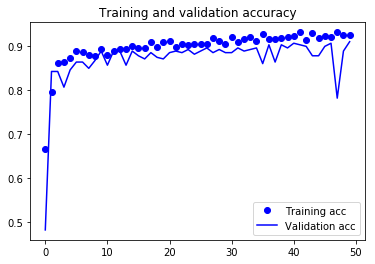

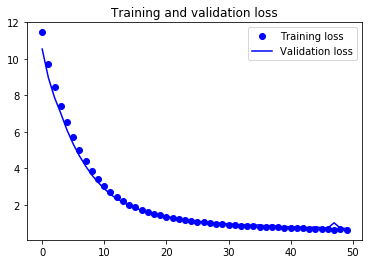

Fold #1


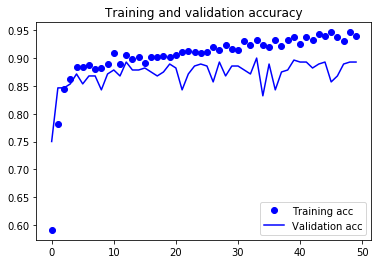

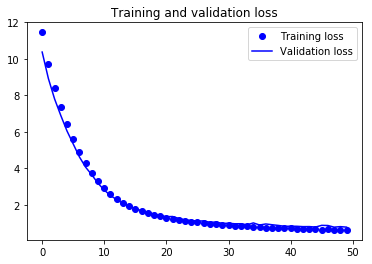

Fold #2


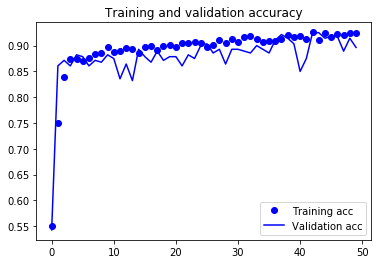

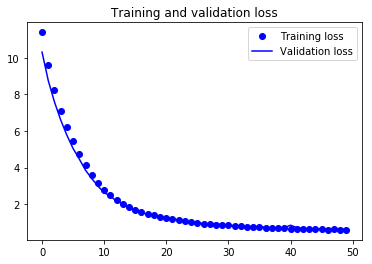

Fold #3


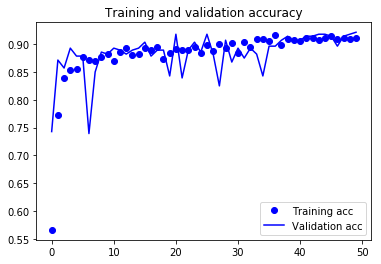

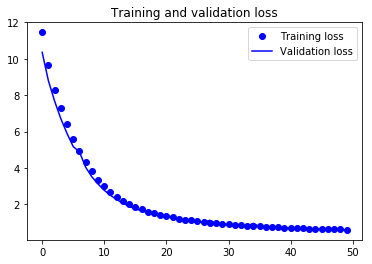

Fold #4


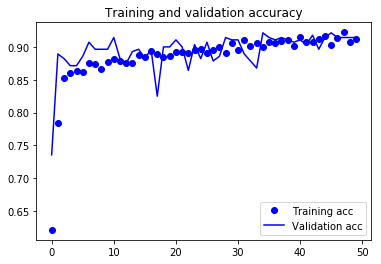

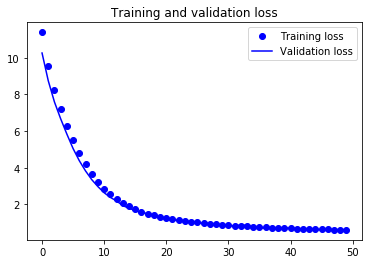

Fold #5


IndexError: list index out of range

In [167]:
for i in range(k):
    print('Fold #' + str(i))
    acc3 = cnn_score[i]
    val_acc3 = cnn_validation_score[i]
    loss3 = cnn_loss[i]
    val_loss3 = cnn_validation_loss[i]
    epochs = 50
    plt.plot(acc3, 'bo', label='Training acc')
    plt.plot(val_acc3, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(loss3, 'bo', label='Training loss')
    plt.plot(val_loss3, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [168]:
start, end = confidence_interval(test_acc)

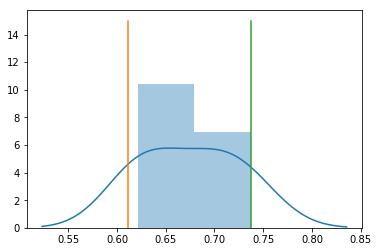

In [169]:
sns.distplot(test_acc);
plt.plot([start, start], [0, 15]);
plt.plot([end, end], [0, 15]);

In [171]:
model1.save('model1.h5')